DNN training module for Hµµ analysis
===

In [ ]:
!mkdir output/trained_models/

In [4]:
def extract_unbinned_data(path, classes, the_channel):
    proc_out = util.load(path)
    unbin_keys = [k for k in list(proc_out.keys()) if 'unbin' in k]
    
    # Get list [var, smp, ch, reg] for every unbinned output accumulator
    items = [[i.split('_unbin_')[0]]+\
                    [i.split('_unbin_')[1].split('_c_')[0]]+\
                    i.split('_unbin_')[1].split('_c_')[1].split('_r_') for i in unbin_keys]
    variables = set()
    samples = set()
    regions = set()
    channels = set()
    for item in items:
        variables.add(item[0])
        samples.add(item[1])
        channels.add(item[2])
        regions.add(item[3])
        
    variables = list(variables)
    dfs = {}
    cls_idx = 0
    import json
    with open('output/lumi_weights.json') as json_file:
        lumi_weights = json.load(json_file)
        for cls, smp_list in classes.items():
            for s in smp_list:
                for r in regions:
                    c = the_channel
                    lbl = f'{c}_channel_{s}_{r}'
                    dfs[lbl] = pd.DataFrame(columns=variables+['class','class_idx'])
                    for v in variables:
                        dfs[lbl][v] = proc_out[f'{v}_unbin_{s}_c_{c}_r_{r}'].value
                    dfs[lbl]['class'] = cls
                    dfs[lbl]['class_idx'] = cls_idx
                    dfs[lbl]['lumi_wgt'] = lumi_weights[s]
                    dfs[lbl] = dfs[lbl].iloc[0:3000]
                    print(lbl)
            cls_idx += 1
    return dfs

def scale_data(inputs):
    x_mean = np.mean(x_train[inputs].values,axis=0)
    x_std = np.std(x_train[inputs].values,axis=0)
    training_data = (x_train[inputs]-x_mean)/x_std
    testing_data = (x_test[inputs]-x_mean)/x_std
    np.save("output/trained_models/scalers", [x_mean, x_std])
    return training_data, testing_data


In [5]:
inputs_binary = {
    'background': ['dy_m105_160_amc', 'ewk_lljj_mll105_160', 'ttjets_dl'],
    'signal': ['ggh_amcPS', 'vbf_amcPS'],
}

inputs_multi = {
    'ggh': ['ggh_amcPS'],
    'vbf': ['vbf_amcPS'],
    'dy': ['dy_m105_160_amc'],
    'ewk': ['ewk_lljj_mll105_160']
}

training_features = ['dimuon_mass', 'dimuon_pt', 'dimuon_eta', 'dimuon_dEta', 'mu1_pt', 'mu2_pt']
other_columns = ['event', 'event_weight', 'lumi_wgt']

In [6]:
from coffea import util
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

load_path = 'output/test_dask.coffea'
    
classes = inputs_binary

# TODO: parallelize loading
df_dict = extract_unbinned_data(load_path, classes, 'vbf')

df = pd.DataFrame()
df = pd.concat(df_dict)

train_fraction = 0.6
df_train = df[df['event']%(1/train_fraction)<1]
df_test = df[df['event']%(1/train_fraction)>=1]
# Check that fraction is correct
print("Training events fraction:", df_train.shape[0]/(df_train.shape[0]+df_test.shape[0]))

x_train = df_train[training_features]
y_train = df_train['class_idx']
x_test = df_test[training_features]
y_test = df_test['class_idx']

for i in range(len(classes)):
    cls_name = list(classes.keys())[i]
    train_evts = len(y_train[y_train==i])
    print(f"{train_evts} training events in class {cls_name}")
    
# scale data
x_train, x_test = scale_data(training_features)
x_test[other_columns] = df_test[other_columns]


vbf_channel_dy_m105_160_amc_h-peak
vbf_channel_dy_m105_160_amc_h-sidebands
vbf_channel_ewk_lljj_mll105_160_h-peak
vbf_channel_ewk_lljj_mll105_160_h-sidebands
vbf_channel_ttjets_dl_h-peak
vbf_channel_ttjets_dl_h-sidebands
vbf_channel_ggh_amcPS_h-peak
vbf_channel_ggh_amcPS_h-sidebands
vbf_channel_vbf_amcPS_h-peak
vbf_channel_vbf_amcPS_h-sidebands
Training events fraction: 0.6011569052783803
4335 training events in class background
3979 training events in class signal


In [7]:
from keras.models import Model
from keras.layers import Dense, Activation, Input, Dropout, Concatenate, Lambda, BatchNormalization
from keras import backend as K

# load model
input_dim = len(training_features)
label = 'test'
inputs = Input(shape=(input_dim,), name = label+'_input')
x = Dense(100, name = label+'_layer_1', activation='tanh')(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(100, name = label+'_layer_2', activation='tanh')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(100, name = label+'_layer_3', activation='tanh')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(1, name = label+'_output',  activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Using TensorFlow backend.
W0123 19:11:18.679472 139726830200640 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0123 19:11:18.701145 139726830200640 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0123 19:11:18.726391 139726830200640 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0123 19:11:18.727339 139726830200640 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 6)                 0         
_________________________________________________________________
test_layer_1 (Dense)         (None, 100)               700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
test_layer_2 (Dense)         (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
__________

In [8]:
# train and save model
history = model.fit(x_train[training_features], y_train, epochs=100, batch_size=2048, verbose=1,
                                    validation_split=0.2, shuffle=True)
model.save('output/trained_models/test.h5')

Train on 6651 samples, validate on 1663 samples
Epoch 1/100
6651/6651 [==============================] - 1s 212us/step - loss: 0.9025 - acc: 0.4932 - val_loss: 0.7826 - val_acc: 0.5370
Epoch 2/100
6651/6651 [==============================] - 0s 18us/step - loss: 0.8128 - acc: 0.5408 - val_loss: 0.7582 - val_acc: 0.4919
Epoch 3/100
6651/6651 [==============================] - 0s 26us/step - loss: 0.7422 - acc: 0.5524 - val_loss: 0.6955 - val_acc: 0.5219
Epoch 4/100
6651/6651 [==============================] - 0s 18us/step - loss: 0.7266 - acc: 0.5474 - val_loss: 0.6932 - val_acc: 0.4853
Epoch 5/100
6651/6651 [==============================] - 0s 16us/step - loss: 0.7202 - acc: 0.5461 - val_loss: 0.7034 - val_acc: 0.4618
Epoch 6/100
6651/6651 [==============================] - 0s 27us/step - loss: 0.6862 - acc: 0.5825 - val_loss: 0.7249 - val_acc: 0.4738
Epoch 7/100
6651/6651 [==============================] - 0s 27us/step - loss: 0.6876 - acc: 0.5873 - val_loss: 0.7444 - val_acc: 0.4672

6651/6651 [==============================] - 0s 16us/step - loss: 0.4654 - acc: 0.7942 - val_loss: 0.4872 - val_acc: 0.7721
Epoch 61/100
6651/6651 [==============================] - 0s 22us/step - loss: 0.4624 - acc: 0.7924 - val_loss: 0.4943 - val_acc: 0.7679
Epoch 62/100
6651/6651 [==============================] - 0s 20us/step - loss: 0.4596 - acc: 0.7948 - val_loss: 0.5017 - val_acc: 0.7709
Epoch 63/100
6651/6651 [==============================] - 0s 18us/step - loss: 0.4699 - acc: 0.7955 - val_loss: 0.5077 - val_acc: 0.7667
Epoch 64/100
6651/6651 [==============================] - 0s 19us/step - loss: 0.4647 - acc: 0.7948 - val_loss: 0.5071 - val_acc: 0.7667
Epoch 65/100
6651/6651 [==============================] - 0s 18us/step - loss: 0.4652 - acc: 0.7978 - val_loss: 0.5079 - val_acc: 0.7667
Epoch 66/100
6651/6651 [==============================] - 0s 17us/step - loss: 0.4600 - acc: 0.7928 - val_loss: 0.5159 - val_acc: 0.7643
Epoch 67/100
6651/6651 [==============================

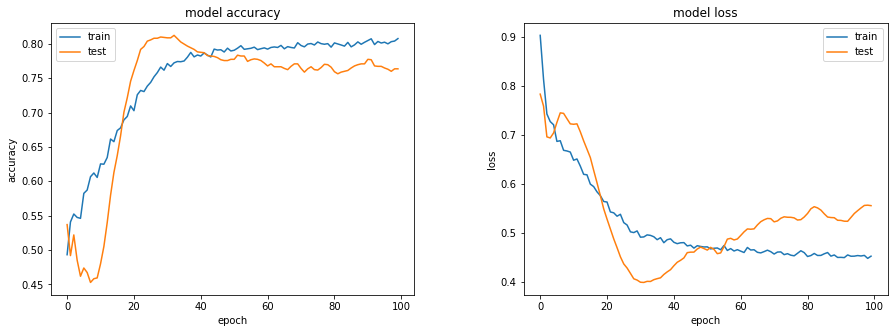

In [13]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='best')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='best')

f.subplots_adjust(wspace=0.3)

In [10]:
from sklearn.metrics import roc_curve
prediction = model.predict(x_test[training_features])
roc = roc_curve(y_test, prediction, sample_weight=x_test['lumi_wgt']*x_test['event_weight'])

In [11]:
def plot_rocs(rocs, title=""):
    plt.clf()
    for name, roc in rocs.items():
        plt.plot(roc[1], roc[0], label=name) # [0]: fpr, [1]: tpr, [2]: threshold
        
    plt.title(title)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Bkg efficiency')
    plt.legend(loc='best', fontsize=12)
    plt.ylim(0.0001, 1)
    plt.yscale("log")
    plt.xlim(0, 1)
#    plt.ylim(0, 1)



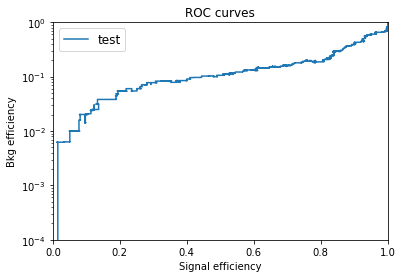

In [12]:
plot_rocs({'test': roc}, 'ROC curves')